In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['lines.linewidth'] = 3

import pandas as pd
pd.set_option("display.precision", 2)
from IPython.display import display
from os import listdir
from functools import reduce

from scipy.optimize import curve_fit
from scipy.constants import m_e, e, mu_0
from collections import namedtuple

# Vorbereitung

### 1. Zyklotronfrequenz eines Elektrons:
$$\omega_c = \frac{q}{m}\cdot B \overset{e^{-}}{=} \frac{e}{m_e}\cdot B$$

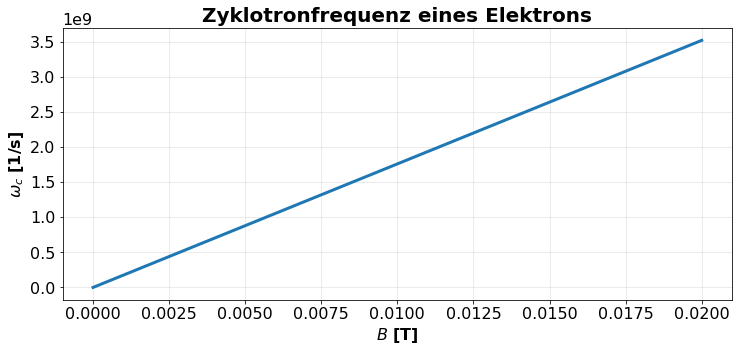

In [2]:
B = np.linspace(0,0.02,100)

plt.figure(figsize=(12,5))
plt.title('Zyklotronfrequenz eines Elektrons')
plt.xlabel('$B$ [T]')
plt.ylabel('$\omega_c$ [1/s]')
plt.plot(B, e/m_e*B)
plt.grid(alpha=.3)
plt.show()

### 2. Axiale, magnetron und (modifizierte) Zyklotronfrequenz:
$$\omega_c = \frac{e}{m_e}\cdot B$$

$$\omega_z = \sqrt{2V_0C_2\cdot\frac{e}{m_e}}$$

$$\omega_m = \omega_{-} = \frac{1}{2}\left( \omega_c - \sqrt{\omega_c^2 - 2\omega_z^2}\right)$$

$$\omega_c' = \omega_{+} = \frac{1}{2}\left( \omega_c + \sqrt{\omega_c^2 - 2\omega_z^2}\right)$$

In [3]:
B = 0.016
V_0 = 40
C_2 = 1.4e4

w_c = e/m_e * B
w_z = np.sqrt(2*V_0*C_2*e/m_e)
sqrt = np.sqrt(w_c**2 - 2*w_z**2)
w_m = 0.5*(w_c - sqrt)
w_p = 0.5*(w_c + sqrt)

w = np.array([w_c, w_z, w_m, w_p]).reshape(1,-1)*1e-6
f = (w / (2*np.pi)).reshape(1,-1)

pd.DataFrame(np.concatenate((w,f)), 
                 index=['$w$ $[1/s]$', '$f$ $[MHz]$'], 
                 columns=['Zyklotron', 'Axial', 'Magnetron', 'Modifiziert'])

,Zyklotron,Axial,Magnetron,Modifiziert
$w$ $[1/s]$,2814.11,443.83,35.45,2778.67
$f$ $[MHz]$,447.88,70.64,5.64,442.24


### 3. Magnetische Flussdichte einer langen Spule
$$ B = \mu_0 \cdot \frac{N}{L} \cdot I$$

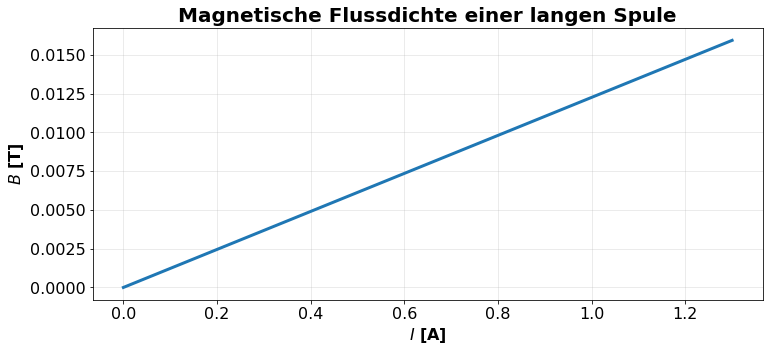

In [4]:
N = 2400
L = 246e-3

I = np.linspace(0,1.3,100)

plt.figure(figsize=(12,5))
plt.title('Magnetische Flussdichte einer langen Spule')
plt.xlabel('$I$ [A]')
plt.ylabel('$B$ [T]')
plt.plot(I, mu_0*N/L*I)
plt.grid(alpha=.3)
plt.show()

# Experiment

### 4. Resonanzfrequenz des Aufbaus:

$$f_{res} = (57.45 \pm 0.03) MHz$$

<img src="img/resonanz.jpeg" width="400">

### 5. Setup für bestmögliches Dip-Signal:

$$f_{res} = 57.35 MHz$$
$$I_{coil} = 1.3 A$$
$$U_{ring} = 39.5 V$$
$$\text{-10dB (damping)}$$
<img src="img/dip.jpeg" width="400">

### 6. Manuelles bestimmen der axialen, magnetron und modifizierten Zyklotronfrequenz:

Vorherige Abschätzungen:
- $B = 0.016 T$
- $\omega_z \approx 4.5\cdot 10^8 Hz$
- $\omega_{mag} \approx 3.5 \cdot 10^7 Hz$
- $\omega_c' \approx 2.8 \cdot 10^9 Hz$
---
Gefundene Werte durch RF-Anregung:
- $f_z \in \left[445.13, 445.29 \right] MHz$
- $f_{mag} \in \left[6.03, 6.42 \right] MHz$
- $f_z \in \left[62.80, 65.84 \right] MHz$

Seitenbänder konnten wir keine finden.

---
Mittels dieser Werte lässt sich der charakteristiscge Wert $C_2$ und das B-Feld abschätzen:

$$C_2 = \frac{\omega_z^2 m_e}{2eV_0} \approx 1.17\cdot10^4m^{-2}$$
$\omega_c$ lässt sich über $\omega_c = \sqrt{f_z^2 + f_{mag}^2 + f_c'^{2}} \cdot 2\pi \approx 2.83 \cdot 10^9 \frac{1}{s}$ bestimmen. Damit folgt für das B-Feld ein Schätzwert von:
$$B = \omega_c \cdot \frac{m_e}{e} \approx 0.016 T$$


### 7. Abschätzung der *Lebenszeit* der Elektronen in der Falle

Zum Abschätzen wird ohne RF-Anregung die Dip-Tiefe für unterschiedliche Zeiten zwischen *Laden* und *Messen* gemessen. Es wird ein linearer Zusammenhang zwischen der Dip-Tiefe und der Elektronenzahl angenommen und ein exponentieller Zerfall gefittet:

$$N(t) = N_0 \cdot e^{-t/\tau} + C_{offset}$$

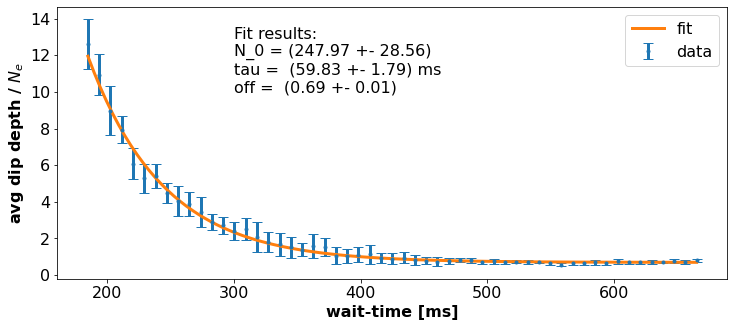

In [5]:
wait, avg, std = np.genfromtxt('data/lifetime_Neumann_Striebel.txt', delimiter=',', unpack=True)
start = 0  

fit_func = lambda t, N0, tau, off: N0*np.exp(-t/tau)+ off
guess = (300,  60,  1)
popt, pcov = curve_fit(fit_func, wait[start:], avg[start:], sigma=std[start:], p0=guess)

N0 = popt[0]
tau = popt[1]
off = popt[2]

N0_err = pcov[0][0]**0.5
tau_err = pcov[1][1]**0.5
off_err = pcov[2][2]**0.5

fit_results=f'''Fit results:
N_0 = ({np.round(N0,2)} +- {np.round(N0_err,2)})
tau =  ({np.round(tau,2)} +- {np.round(tau_err,2)}) ms
off =  ({np.round(off,2)} +- {np.round(off_err,2)})'''

t = np.linspace(min(wait), max(wait), 100)

plt.figure(figsize=(12,5))
plt.errorbar(wait, avg, yerr=std, label='data', capsize=5, fmt='.')
plt.xlabel('wait-time [ms]')
plt.ylabel('avg dip depth / $N_e$')
plt.plot(t, fit_func(t, *popt), label='fit')
plt.legend(fontsize=16)
plt.text(300, 10, fit_results, size=16)

plt.savefig('lifetime.png')
plt.show()




Die "Lebensdauer" kann also mit 
$$\tau \approx 60 ms$$
abgechätzt werden. Allerdings ist der lineare Zusammenhang zwischen Dip-Tiefe und Elektronenzahl nicht sehr realistisch.

### 8. Langzeitmessung

Es werden mehrere Frequenz-Scans mit 
- variierender Anregungs-Amplitude
- variierender Fallen-Spannung
- variierendem Spulen-Strom
durchgeführt (siehe Auswertung)

# Auswertung

### *Vorbereitung*

In [6]:
'''data_preperation'''

data_path = './data'

data = {
    file: np.genfromtxt(f'{data_path}/{file}', delimiter=',', unpack=True)
    for file in listdir(data_path)
    if file.split('.')[-1]=='csv'
}

file_names = sorted([
    file 
    for file in listdir(data_path)
    if file.split('.')[-1]=='csv'
])

#sort after measurement sequence
data_ep = {
    file: data[file]
    for file in file_names[0:12]
}
data_U = {
    file: data[file]
    for file in file_names[12:30]
}
data_I = {
    file: data[file]
    for file in file_names[30:45]
}


assert len(data) == len(data_ep) + len(data_I) + len(data_U)
    
# stack each measurement with setup
excitation_powers = [-5,0,5,10]
ring_voltages = [20,25,30,35,40,45]
coil_currents = [1.1, 1.15, 1.2, 1.25, 1.3]



data_ep_stack = {
    ep: np.concatenate([
        data_ep[file] for file in data_ep.keys() if file.split('_')[-1] == f'{ep}dBm.csv'
    ], axis=1)
    for ep in excitation_powers
}
data_U_stack = {
    U: np.concatenate([
        data_U[file] for file in data_U.keys() if file.split('_')[-4] == f'{U}V'
    ], axis=1)
    for U in ring_voltages
}
data_I_stack = {
    I: np.concatenate([
        data_I[file] for file in data_I.keys() if file.split('_')[-3] == f'{I}A'
    ], axis=1)
    for I in coil_currents
}

In [7]:
'''data visualization'''
def plot_broken(data_dict, unit='units', title='title', ymin=0, ymax=30):
    f,(ax,ax2,ax3) = plt.subplots(1,3,
                                  sharey=False, 
                                  facecolor='w', 
                                  figsize=(15,5), 
                                  #tight_layout=True,
                                  gridspec_kw = {'wspace':0.05, 'hspace':0.05, 
                                      'width_ratios': [9, 50,200]}
                                 )

    ax.set_xlim(1,10)
    ax2.set_xlim(30,80)
    ax3.set_xlim(300,500)
    
    ax.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    ax3.set_ylim(ymin, ymax)

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    #ax2.yaxis.tick_right()
    ax2.yaxis.set_ticks([])
    ax3.yaxis.tick_right()
    
    for key in data_dict.keys():
        data = data_dict[key]
        ax.plot(data[0],data[1], lw=1)
        ax2.plot(data[0],data[1], lw=1)
        ax3.plot(data[0],data[1], label=f'{key} {unit}', lw=1)
    ax3.legend()
    
    for a in (ax,ax2,ax3):
        for tick in a.get_xticklabels():
            tick.set_rotation(90)
            
    f.suptitle(title, fontsize=20, fontweight='bold')
    
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    d1 = .015*50/9
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d1,1+d1), (-d,+d), **kwargs, lw=2)
    ax.plot((1-d1,1+d1),(1-d,1+d), **kwargs, lw=2)

    d1 = .015
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((0-d1,0+d1), (1-d,1+d), **kwargs, lw=2)
    ax2.plot((0-d1,0+d1), (-d,+d), **kwargs, lw=2)
    ax2.plot((1-d1,1+d1), (-d,+d), **kwargs, lw=2)
    ax2.plot((1-d1,1+d1),(1-d,1+d), **kwargs, lw=2)
    
    d1 = .015*50/200
    kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
    ax3.plot((0-d1,0+d1), (1-d,1+d), **kwargs, lw=2)
    ax3.plot((0-d1,0+d1), (-d,+d), **kwargs, lw=2)
    
    f.text(0.5, -0.03, 'f [MHz]', ha='center', fontsize=14, fontweight='bold')
    return f, (ax,ax2,ax3)

### 9. Identifizieren der verschiedenen Linien
Um die verschiedenen Linien zu identifizieren werden die Daten genauer untersucht. Es werden nur die deutlichen Minima gefittet.

In [8]:
Peak = namedtuple('Peak', ['I', 'U', 'P_e', 'f', 'sigma'])
MAGNETRON = []
AXIAL = []
MOD = []
ZYKLOTRON = []

Es wird eine Plateau-Funktion gefittet. 

Referenz: Wu, Chen-Wu. (2015). A plateau function. doi: 10.13140/RG.2.1.3641.4568

$$C-\Pi(x) = c \cdot e^{-((x-a)/b)^{2n}}$$

- a: Center des Plateus
- b: Breite des Plateus is 2|b|
- c: Wert im Platue Bereich
- n: je größer n desto schärfer die Kante

In [9]:
def C_PI(x,a,b,c,y,n):
    return c*np.exp(-np.power((x-a)/b,2*n)) + y

In [10]:
def fit_peak(data, indices, guess=None,n=1,ax=None, title=None):
    x = data[0][indices[0]: indices[1]]
    y = data[1][indices[0]: indices[1]]
    
    def cpi(x,a,b,c,y):
        return c*np.exp(-np.power((x-a)/b,2*n)) + y
    
    popt, pcov = curve_fit(cpi, x, y, p0=guess, maxfev=1000000)
    x_line = np.linspace(min(x), max(x), 200)
    if ax: 
        ax.plot(x,y, alpha=0.3)
        ax.scatter(x,y, label='data')
        ax.plot(x_line, cpi(x_line, *popt), color='orange', label='fit')
        ax.legend()
        ax.set_xlabel('f [MHz]')
        ax.set_title(title)

    peak = popt[0]
    peak_err = pcov[0][0]**0.5
    width = np.abs(popt[1])
    if width > peak_err:
        peak_err = width
    return peak, peak_err, popt, pcov, n

#### 9.1 Variiende Anregungsleistung
- für die Magnetron und axiale Frequenz werden die -5dBm und 0dBm Messreihen verwendet
- für die modifizierte Zyklotornfrequenz werden die -5dBm und die 10dBm Messreihen verwendet 

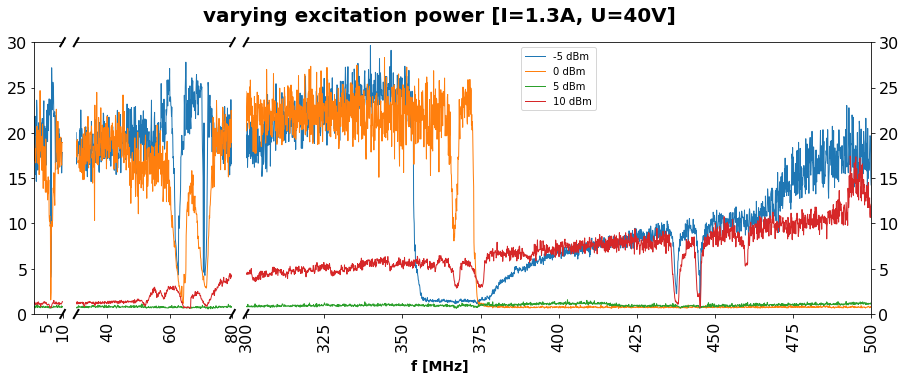

In [11]:
'''Übersicht'''
_=plot_broken(data_ep_stack, unit='dBm', title='varying excitation power [I=1.3A, U=40V]')

In [12]:
#Filtern der Daten
minus5dbm = data_ep_stack[-5]
nulldbm = data_ep_stack[0]
plus10dbm = data_ep_stack[10]

##### 9.1.1 Magnetronfrequenz

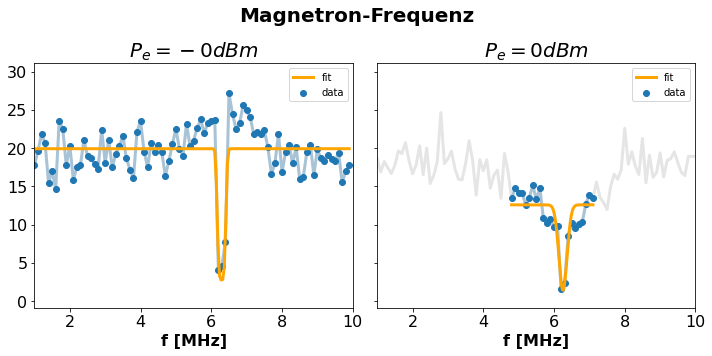

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,sharex=True, figsize=(10,5), tight_layout=True)
fig.suptitle('Magnetron-Frequenz', size=20, fontweight='bold')
guess=[6.28,0.15,-17,22]
peak, err, p, cov, n = fit_peak(minus5dbm, (0,90), 
                                guess=guess, n=2,
                                ax=ax1, title='$P_e=-0dBm$')
MAGNETRON.append(Peak(1.3,40,-5,peak,err))
peak, err, p, cov, n = fit_peak(nulldbm, (38,62), 
                                guess=guess, n=1,
                                ax=ax2, title='$P_e=0dBm$')
MAGNETRON.append(Peak(1.3,40,0,peak,err))

ax1.plot(minus5dbm[0], minus5dbm[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(nulldbm[0], nulldbm[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(1,10)

In [14]:
#pd.DataFrame(MAGNETRON, columns=['I [A]', 'U[V]', '$P_e$ [dBm]', 'f [Hz]', '$\sigma_f$ [MHz]'])


##### 9.1.2 Axiale Frequenz

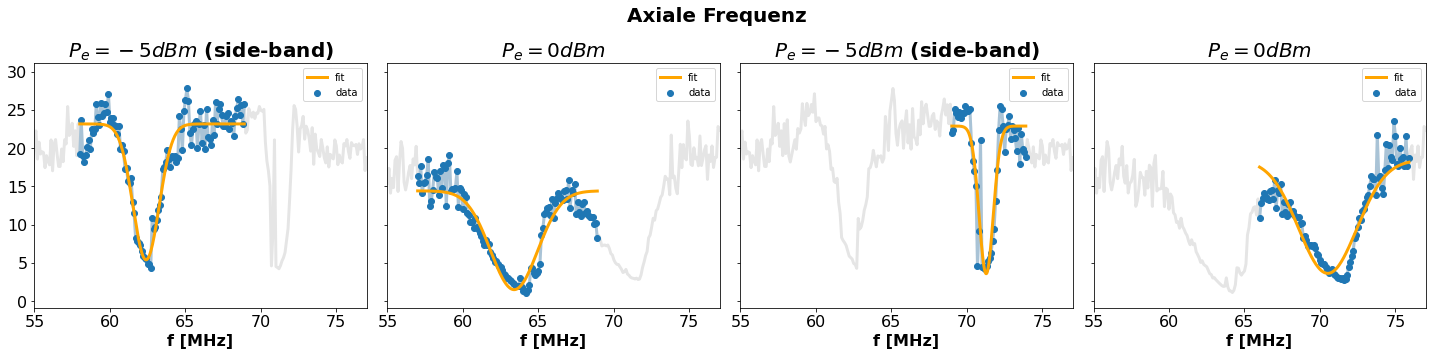

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,sharey=True,sharex=True, figsize=(20,5), tight_layout=True)
fig.suptitle('Axiale Frequenz', size=20, fontweight='bold')
#first peak
guess=[62,3,-17,22]
peak, err, p, cov, n = fit_peak(minus5dbm, (370,480), 
                                guess=guess, n=1,
                                ax=ax1, title='$P_e=-5dBm$ (side-band)')
#AXIAL.append(Peak(1.3,40,-5,peak,err))
peak, err, p, cov, n = fit_peak(nulldbm, (360,480), 
                                guess=guess, n=1,
                                ax=ax2, title='$P_e=0dBm$')
AXIAL.append(Peak(1.3,40,0,peak,err))

#second peak
guess=[71,3,-17,22]
peak, err, p, cov, n = fit_peak(minus5dbm, (480,530), 
                                guess=guess, n=1,
                                ax=ax3, title='$P_e=-5dBm$ (side-band)')
#AXIAL.append(Peak(1.3,40,-5,peak,err))
peak, err, p, cov, n = fit_peak(nulldbm, (450,550), 
                                guess=guess, n=1,
                                ax=ax4, title='$P_e=0dBm$')
AXIAL.append(Peak(1.3,40,0,peak,err))

ax1.plot(minus5dbm[0], minus5dbm[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(nulldbm[0], nulldbm[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(minus5dbm[0], minus5dbm[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(nulldbm[0], nulldbm[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(55,77)

##### 9.1.3 (Gedämpfte) Zyklotronfrequenz

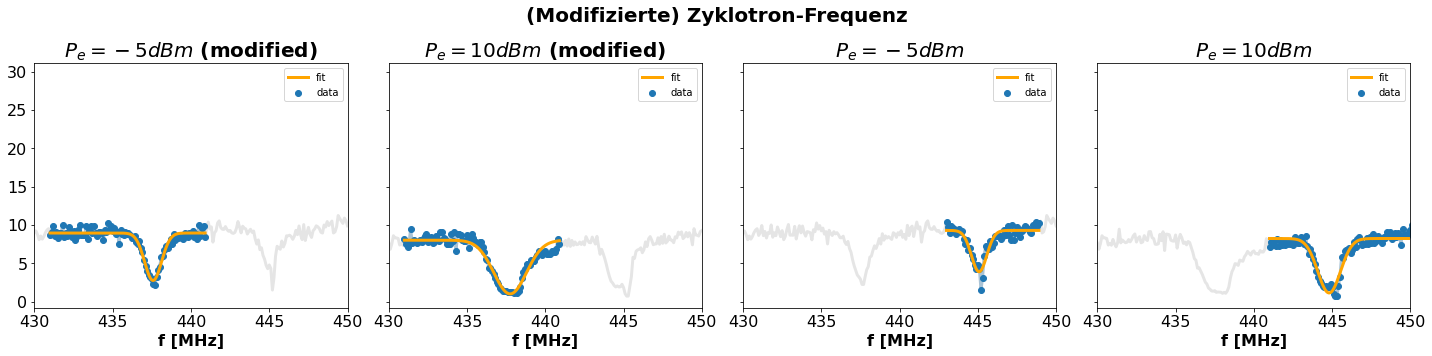

In [16]:
#modified
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,sharey=True,sharex=True, figsize=(20,5), tight_layout=True)
fig.suptitle('(Modifizierte) Zyklotron-Frequenz', size=20, fontweight='bold')
guess=[435,3,-17,22]
peak, err, p, cov, n = fit_peak(minus5dbm, (1900,2000), 
                                guess=guess, n=1, 
                                ax=ax1, title='$P_e=-5dBm$ (modified)')
MOD.append(Peak(1.3,40,-5,peak,err))
peak, err, p, cov, n = fit_peak(plus10dbm, (1900,2000), 
                                guess=guess, n=1, 
                                ax=ax2, title='$P_e=10dBm$ (modified)')
MOD.append(Peak(1.3,40,10,peak,err))

#zyklotron
guess=[445,3,-17,22]
peak, err, p, cov, n = fit_peak(minus5dbm, (2020,2080), 
                                guess=guess, n=1,
                                ax=ax3, title='$P_e=-5dBm$')
ZYKLOTRON.append(Peak(1.3,40,-5,peak,err))
peak, err, p, cov, n = fit_peak(plus10dbm, (2000,2100), 
                                guess=guess, n=1,
                                ax=ax4, title='$P_e=10dBm$')
ZYKLOTRON.append(Peak(1.3,40,10,peak,err))

ax1.plot(minus5dbm[0], minus5dbm[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(plus10dbm[0], plus10dbm[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(minus5dbm[0], minus5dbm[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(plus10dbm[0], plus10dbm[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(430,450)

#### 9.2 Variiende Ringspannung
- für die Magnetronfrequenz und axiale Frequenz werden die Messungen mit 30-45V genutzt
- für die (gedämpfte) Zyklotron-Frequenz werden ebenfalls die Messungen 30-45V genutzt

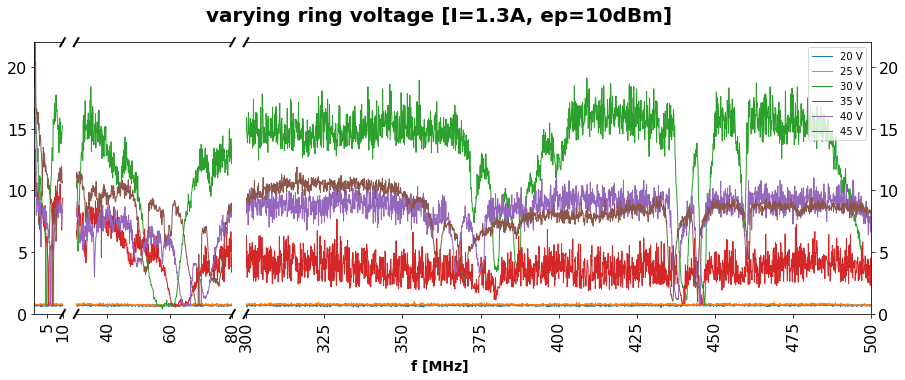

In [17]:
_=plot_broken(data_U_stack, unit='V', title='varying ring voltage [I=1.3A, ep=10dBm]',ymax=22)

In [18]:
#Filtern der Daten
Volt30 = data_U_stack[30]
Volt35 = data_U_stack[35]
Volt40 = data_U_stack[40]
Volt45 = data_U_stack[45]

##### 9.2.1 Magnetrongfrequenz

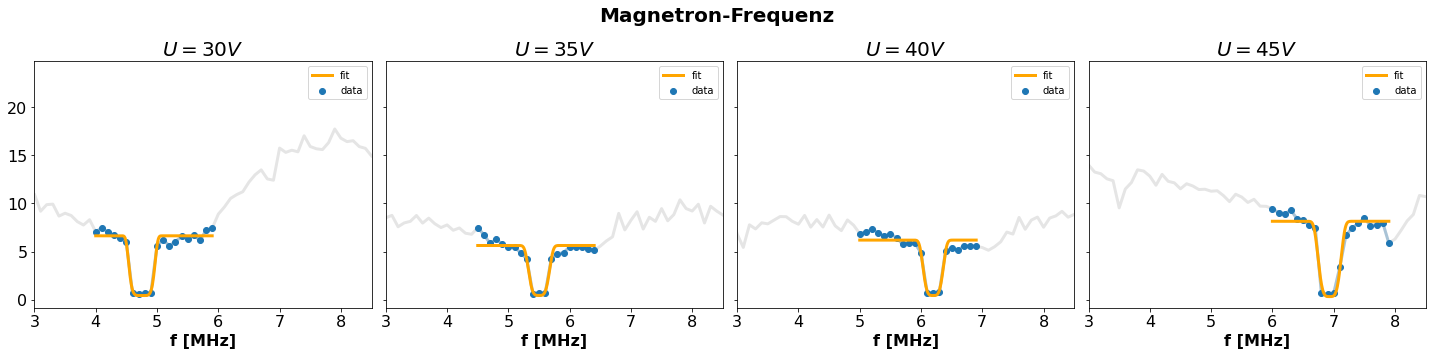

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,sharey=True,sharex=True, figsize=(20,5), tight_layout=True)
fig.suptitle('Magnetron-Frequenz', size=20, fontweight='bold')
guess=[4.7,1,-17,22]
peak, err, p, cov, n = fit_peak(Volt30, (30,50), 
                                guess=guess, n=3,
                                ax=ax1, title='$U=30V$')
MAGNETRON.append(Peak(1.3,30,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt35, (35,55), 
                                guess=guess, n=2,
                                ax=ax2, title='$U=35V$')
MAGNETRON.append(Peak(1.3,35,10,peak, err))
guess=[6.1,1,-17,22]
peak, err, p, cov, n = fit_peak(Volt40, (40,60), 
                                guess=guess, n=2,
                                ax=ax3, title='$U=40V$')
MAGNETRON.append(Peak(1.3,40,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt45, (50,70), 
                                guess=guess, n=2,
                                ax=ax4, title='$U=45V$')
MAGNETRON.append(Peak(1.3,45,10,peak, err))

ax1.plot(Volt30[0], Volt30[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(Volt35[0], Volt35[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(Volt40[0], Volt40[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(Volt45[0], Volt45[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(3,8.5)

##### 9.2.2 Axiale Frequenz

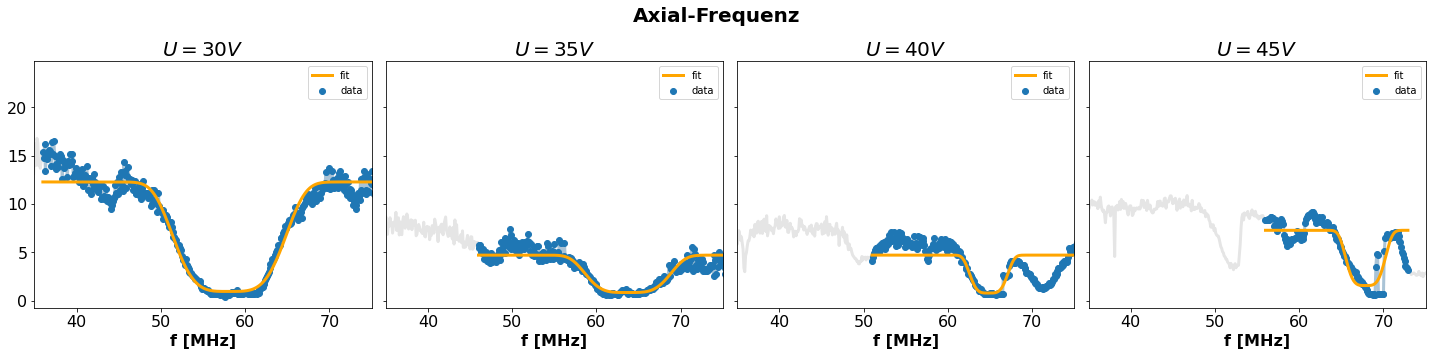

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,sharey=True,sharex=True, figsize=(20,5), tight_layout=True)
fig.suptitle('Axial-Frequenz', size=20, fontweight='bold')
guess=[60,5,-10,12]
peak, err, p, cov, n = fit_peak(Volt30, (150,550), 
                                guess=guess, n=2,
                                ax=ax1, title='$U=30V$')
AXIAL.append(Peak(1.3,30,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt35, (250,550), 
                                guess=guess, n=2, 
                                ax=ax2, title='$U=35V$')
AXIAL.append(Peak(1.3,35,10,peak, err))
guess=[65,2,-5,5]
peak, err, p, cov, n = fit_peak(Volt40, (300,550), 
                                guess=guess, n=2, 
                                ax=ax3, title='$U=40V$')
AXIAL.append(Peak(1.3,40,10,peak, err))
guess=[70,2,-5,5]
peak, err, p, cov, n = fit_peak(Volt45, (350,520), 
                                guess=guess, n=2,
                                ax=ax4, title='$U=45V$')
AXIAL.append(Peak(1.3,45,10,peak, err))

ax1.plot(Volt30[0], Volt30[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(Volt35[0], Volt35[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(Volt40[0], Volt40[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(Volt45[0], Volt45[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(35,75)

##### 9.2.3 (Modifizierte) Zyklotronfrequenz

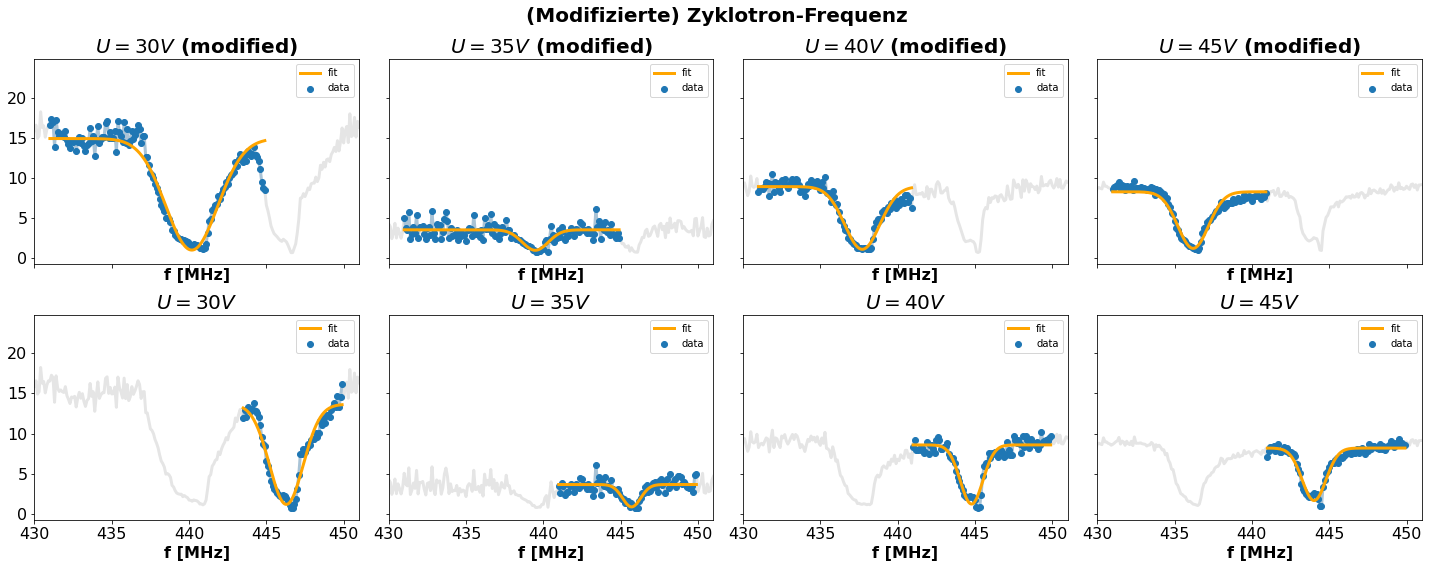

In [21]:
fig, axs = plt.subplots(2,4,sharey=True,sharex=True, figsize=(20,8), tight_layout=True)
fig.suptitle('(Modifizierte) Zyklotron-Frequenz', size=20, fontweight='bold')
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

guess=[440,5,-10,12]
peak, err, p, cov, n = fit_peak(Volt30, (1900,2040), 
                                guess=guess, n=1,
                                ax=ax1, title='$U=30V$ (modified)')
MOD.append(Peak(1.3,30,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt30, (2025,2090), 
                                guess=guess, n=1,
                                ax=ax5, title='$U=30V$')
ZYKLOTRON.append(Peak(1.3,30,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt35, (1900,2040), 
                                guess=guess, n=1,
                                ax=ax2, title='$U=35V$ (modified)')
MOD.append(Peak(1.3,35,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt35, (2000,2090), 
                                guess=guess, n=1,
                                ax=ax6, title='$U=35V$')
ZYKLOTRON.append(Peak(1.3,35,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt40, (1900,2000), 
                                guess=guess, n=1,
                                ax=ax3, title='$U=40V$ (modified)')
MOD.append(Peak(1.3,40,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt40, (2000,2090), 
                                guess=guess, n=1,
                                ax=ax7, title='$U=40V$')
ZYKLOTRON.append(Peak(1.3,40,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt45, (1900,2000), 
                                guess=guess, n=1,
                                ax=ax4, title='$U=45V$ (modified)')
MOD.append(Peak(1.3,45,10,peak, err))
peak, err, p, cov, n = fit_peak(Volt45, (2000,2090), 
                                guess=guess, n=1,
                                ax=ax8, title='$U=45V$')
ZYKLOTRON.append(Peak(1.3,45,10,peak, err))

ax1.plot(Volt30[0], Volt30[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(Volt35[0], Volt35[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(Volt40[0], Volt40[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(Volt45[0], Volt45[1], color='k', alpha=0.1, zorder=-1)
ax5.plot(Volt30[0], Volt30[1], color='k', alpha=0.1, zorder=-1)
ax6.plot(Volt35[0], Volt35[1], color='k', alpha=0.1, zorder=-1)
ax7.plot(Volt40[0], Volt40[1], color='k', alpha=0.1, zorder=-1)
ax8.plot(Volt45[0], Volt45[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(430,451)

#### 9.3 Variiender Spulenstrom
- hier könne alle Messungen genutzt werden

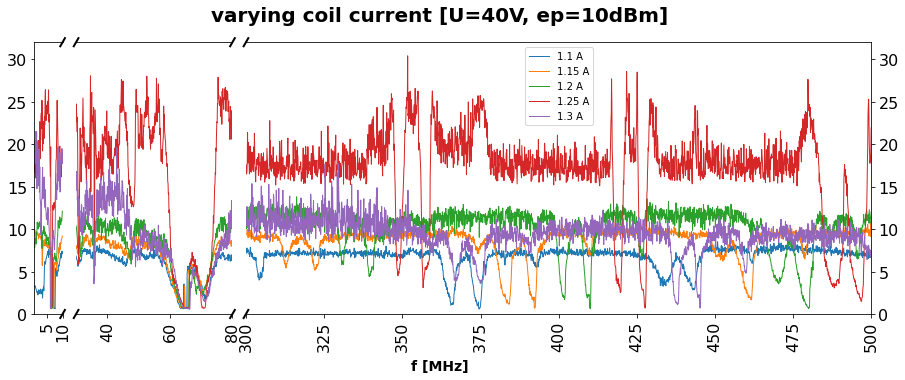

In [22]:
_=plot_broken(data_I_stack, unit='A', title='varying coil current [U=40V, ep=10dBm]', ymax=32)

In [23]:
#Filtern der Daten
A1_10 = data_I_stack[1.1]
A1_15 = data_I_stack[1.15]
A1_20 = data_I_stack[1.2]
A1_25 = data_I_stack[1.25]
A1_30 = data_I_stack[1.30]

##### 9.3.1 Magnetronfrequenz

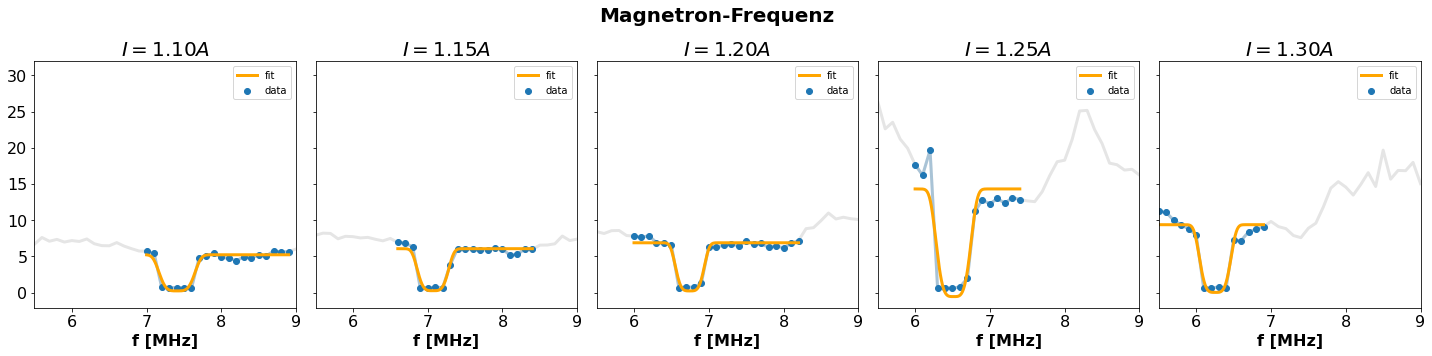

In [24]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,sharey=True,sharex=True, figsize=(20,5), tight_layout=True)
fig.suptitle('Magnetron-Frequenz', size=20, fontweight='bold')
guess=[7.3,1,-5,5]
peak, err, p, cov, n = fit_peak(A1_10, (60,80), 
                                guess=guess, n=2,
                                ax=ax1, title='$I=1.10A$')
MAGNETRON.append(Peak(1.1,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_15, (56,75), 
                                guess=guess, n=2,
                                ax=ax2, title='$I=1.15A$')
MAGNETRON.append(Peak(1.15,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_20, (50,73), 
                                guess=guess, n=2,
                                ax=ax3, title='$I=1.20A$')
MAGNETRON.append(Peak(1.20,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_25, (50,65), 
                                guess=guess, n=2,
                                ax=ax4, title='$I=1.25A$')
MAGNETRON.append(Peak(1.25,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_30, (45,60), 
                                guess=guess, n=2,
                                ax=ax5, title='$I=1.30A$')
MAGNETRON.append(Peak(1.3,40,10,peak, err))

ax1.plot(A1_10[0], A1_10[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(A1_15[0], A1_15[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(A1_20[0], A1_20[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(A1_25[0], A1_25[1], color='k', alpha=0.1, zorder=-1)
ax5.plot(A1_30[0], A1_30[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(5.5,9)

##### 9.3.2 Axiale Frequenz

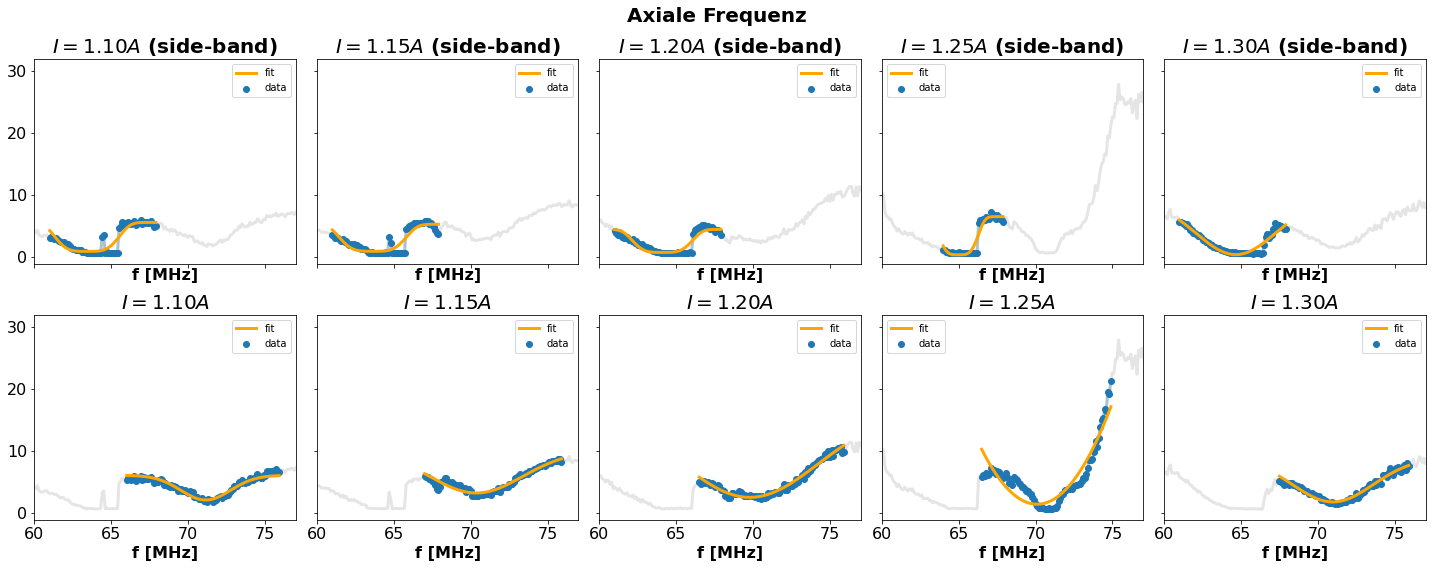

In [25]:
fig, axs = plt.subplots(2,5,sharey=True,sharex=True, figsize=(20,8), tight_layout=True)
fig.suptitle('Axiale Frequenz', size=20, fontweight='bold')
ax1, ax2, ax3, ax4, ax5  = axs[0]
ax6, ax7, ax8, ax9, ax10 = axs[1]

guess=[65,5,-7,7]
peak, err, p, cov, n = fit_peak(A1_10, (400,470), 
                                guess=guess, n=2,
                                ax=ax1, title='$I=1.10A$ (side-band)')
peak, err, p, cov, n = fit_peak(A1_10, (450,550), 
                                guess=guess, n=1,
                                ax=ax6, title='$I=1.10A$')
AXIAL.append(Peak(1.1,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_15, (400,470), 
                                guess=guess, n=2,
                                ax=ax2, title='$I=1.15A$ (side-band)')
peak, err, p, cov, n = fit_peak(A1_15, (460,550), 
                                guess=guess, n=1,
                                ax=ax7, title='$I=1.15A$')
AXIAL.append(Peak(1.15,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_20, (400,470), 
                                guess=guess, n=2,
                                ax=ax3, title='$I=1.20A$ (side-band)')
peak, err, p, cov, n = fit_peak(A1_20, (455,550), 
                                guess=guess, n=1,
                                ax=ax8, title='$I=1.20A$')
AXIAL.append(Peak(1.2,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_25, (430,470), 
                                guess=guess, n=2,
                                ax=ax4, title='$I=1.25A$ (side-band)')
peak, err, p, cov, n = fit_peak(A1_25, (455,540), 
                                guess=guess, n=1,
                                ax=ax9, title='$I=1.25A$')
#AXIAL.append(Peak(1.25,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_30, (400,470), 
                                guess=guess, n=1,
                                ax=ax5, title='$I=1.30A$ (side-band)')
peak, err, p, cov, n = fit_peak(A1_30, (465,550), 
                                guess=guess, n=1,
                                ax=ax10, title='$I=1.30A$')
AXIAL.append(Peak(1.30,40,10,peak, err))

ax1.plot(A1_10[0], A1_10[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(A1_15[0], A1_15[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(A1_20[0], A1_20[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(A1_25[0], A1_25[1], color='k', alpha=0.1, zorder=-1)
ax5.plot(A1_30[0], A1_30[1], color='k', alpha=0.1, zorder=-1)
ax6.plot(A1_10[0], A1_10[1], color='k', alpha=0.1, zorder=-1)
ax7.plot(A1_15[0], A1_15[1], color='k', alpha=0.1, zorder=-1)
ax8.plot(A1_20[0], A1_20[1], color='k', alpha=0.1, zorder=-1)
ax9.plot(A1_25[0], A1_25[1], color='k', alpha=0.1, zorder=-1)
ax10.plot(A1_30[0], A1_30[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(60,77)

Die Fits sind nicht sehr gut aber auch das betrachten der einzelnen Daten zeigt: die axiale Frequenz hängt nicht vom Spulenstrom (also der Magnetfeldstärke) ab.

##### 9.3.3 (Modifizierte) Zyklotronfrequenz

Wir fitten nur die *mittleren* Frequenzen (nicht die Seitenbänder (siehe Plot 9.3.4))

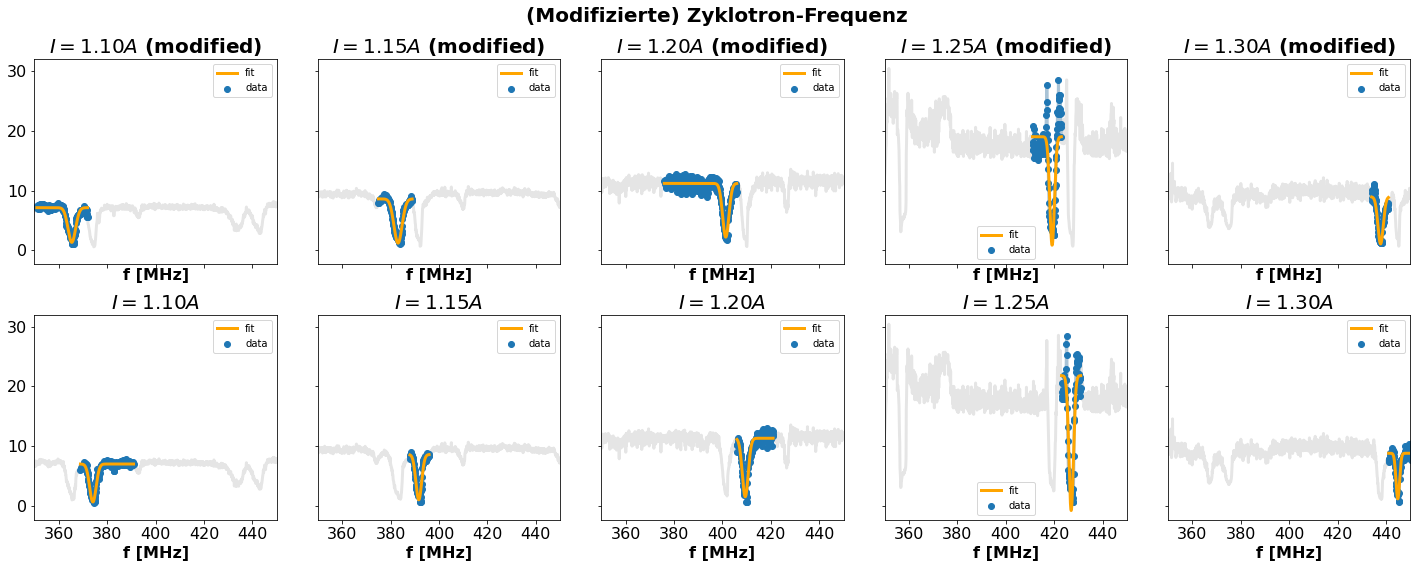

In [26]:
fig, axs = plt.subplots(2,5,sharey=True,sharex=True, figsize=(20,8), tight_layout=True)
fig.suptitle('(Modifizierte) Zyklotron-Frequenz', size=20, fontweight='bold')
ax1, ax2, ax3, ax4, ax5  = axs[0]
ax6, ax7, ax8, ax9, ax10 = axs[1]

guess=[370,5,-8,8]
peak, err, p, cov, n = fit_peak(A1_10, (1100,1310), 
                                guess=guess, n=1,
                                ax=ax1, title='$I=1.10A$ (modified)')
MOD.append(Peak(1.1,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_10, (1280,1500), 
                                guess=guess, n=1,
                                ax=ax6, title='$I=1.10A$')
ZYKLOTRON.append(Peak(1.1,40,10,peak, err))
guess=[385,5,-8,8]
peak, err, p, cov, n = fit_peak(A1_15, (1340,1480), 
                                guess=guess, n=1,
                                ax=ax2, title='$I=1.15A$ (modified)')
MOD.append(Peak(1.15,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_15, (1470,1550), 
                                guess=guess, n=1,
                                ax=ax7, title='$I=1.15A$')
ZYKLOTRON.append(Peak(1.15,40,10,peak, err))
guess=[400,5,-8,8]
peak, err, p, cov, n = fit_peak(A1_20, (1350,1650), 
                                guess=guess, n=1,
                                ax=ax3, title='$I=1.20A$ (modified)')
MOD.append(Peak(1.2,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_20, (1650,1800), 
                                guess=guess, n=1,
                                ax=ax8, title='$I=1.20A$')
ZYKLOTRON.append(Peak(1.20,40,10,peak, err))
guess=[420,5,-8,8]
peak, err, p, cov, n = fit_peak(A1_25, (1700,1820), 
                                guess=guess, n=1,
                                ax=ax4, title='$I=1.25A$ (modified)')
MOD.append(Peak(1.25,40,10,peak, err))
guess=[430,5,-8,8]
peak, err, p, cov, n = fit_peak(A1_25, (1820,1900), 
                                guess=guess, n=1,
                                ax=ax9, title='$I=1.25A$')
ZYKLOTRON.append(Peak(1.25,40,10,peak, err))
guess=[440,5,-8,8]
peak, err, p, cov, n = fit_peak(A1_30, (1930,2000), 
                                guess=guess, n=1,
                                ax=ax5, title='$I=1.30A$ (modified)')
MOD.append(Peak(1.3,40,10,peak, err))
peak, err, p, cov, n = fit_peak(A1_30, (2000,2100), 
                                guess=guess, n=1,
                                ax=ax10, title='$I=1.30A$')
ZYKLOTRON.append(Peak(1.30,40,10,peak, err))

ax1.plot(A1_10[0], A1_10[1], color='k', alpha=0.1, zorder=-1)
ax2.plot(A1_15[0], A1_15[1], color='k', alpha=0.1, zorder=-1)
ax3.plot(A1_20[0], A1_20[1], color='k', alpha=0.1, zorder=-1)
ax4.plot(A1_25[0], A1_25[1], color='k', alpha=0.1, zorder=-1)
ax5.plot(A1_30[0], A1_30[1], color='k', alpha=0.1, zorder=-1)
ax6.plot(A1_10[0], A1_10[1], color='k', alpha=0.1, zorder=-1)
ax7.plot(A1_15[0], A1_15[1], color='k', alpha=0.1, zorder=-1)
ax8.plot(A1_20[0], A1_20[1], color='k', alpha=0.1, zorder=-1)
ax9.plot(A1_25[0], A1_25[1], color='k', alpha=0.1, zorder=-1)
ax10.plot(A1_30[0], A1_30[1], color='k', alpha=0.1, zorder=-1)
_=ax1.set_xlim(350,450)

Hier kann man schon die Seitenbänder erahnen.
##### 9.3.4 Seitenbänder der (modifizierten) Zyklotronfrequenz

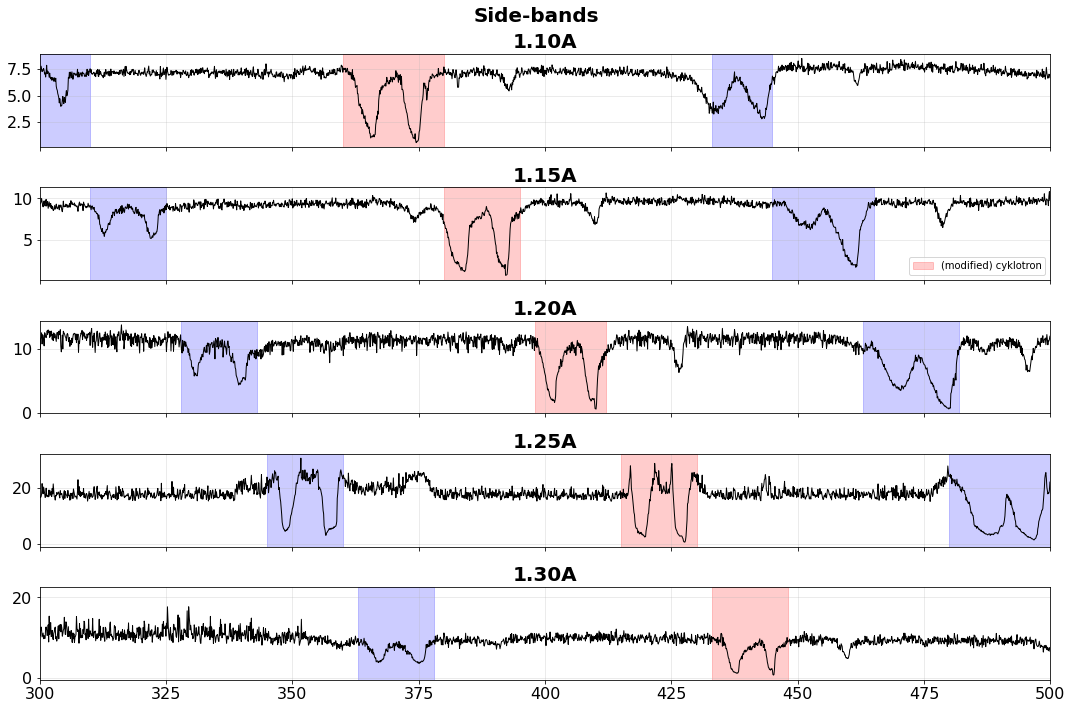

In [27]:
def plot_band(data, small=None, middle=None, large=None, ax=None, title=None):
    if middle is not None: ax.axvspan(middle[0], middle[1], alpha=0.2, color='red', label='(modified) cyklotron')
    if small is not None: ax.axvspan(small[0], small[1], alpha=0.2, color='blue')
    if large is not None: ax.axvspan(large[0], large[1], alpha=0.2, color='blue')
    ax.plot(data[0], data[1], color='k', lw=1)
    ax.set_title(title)
    ax.grid(alpha=0.3)
    
all_A = [A1_10,A1_15,A1_20,A1_25,A1_30]
titles = ['1.10A', '1.15A', '1.20A', '1.25A', '1.30A']
middle = [(360,380),(380,395), (398,412), (415,430),(433,448)]
small = [(300,310), (310,325), (328,343), (345,360),(363,378)]
large = [(433,445), (445,465), (463,482), (480,500), None]
fig, axs = plt.subplots(5,1, tight_layout='True', sharex=True, figsize=(15,10))
fig.suptitle('Side-bands', size=20, fontweight='bold')
for data, ax, t, s, m, l in zip(all_A, axs, titles, small, middle, large):
    plot_band(data, ax=ax, title=t, small=s, middle=m, large=l)

axs[0].set_xlim(300,500)
_=axs[1].legend()

#### 9.4 Zusammenfassung der Fits

In [28]:
df_mag = pd.DataFrame(MAGNETRON, columns=['I [A]', 'U [V]', '$P_e$ [dBm]', '$f_{-}$ [MHz]', '$\sigma_{f_-}$ [MHz]'])
df_axi = pd.DataFrame(AXIAL,     columns=['I [A]', 'U [V]', '$P_e$ [dBm]', '$f_{z}$ [MHz]', '$\sigma_{f_z}$ [MHz]'])
df_mod = pd.DataFrame(MOD,       columns=['I [A]', 'U [V]', '$P_e$ [dBm]', '$f_{+}$ [MHz]', '$\sigma_{f_+}$ [MHz]'])
df_zyk = pd.DataFrame(ZYKLOTRON, columns=['I [A]', 'U [V]', '$P_e$ [dBm]', '$f_{c}$ [MHz]', '$\sigma_{f_c}$ [MHz]'])

# We have multiple results for I=1.3A, U=40V and P_e=10dBm
# => calculate the mean, as an error we
fs = ['$f_{-}$ [MHz]', '$f_{z}$ [MHz]', '$f_{+}$ [MHz]', '$f_{c}$ [MHz]']
sigs = ['$\sigma_{f_-}$ [MHz]', '$\sigma_{f_z}$ [MHz]', '$\sigma_{f_+}$ [MHz]', '$\sigma_{f_c}$ [MHz]']
all_dfs = [df_mag, df_axi, df_mod, df_zyk] 
def sigma_by_gauss(errors):
    squared_sum = np.sum(errors**2)
    return np.sqrt(squared_sum) / len(errors)

all_dfs = [
    df.groupby(['I [A]', 'U [V]', '$P_e$ [dBm]']).agg(
        {
            f : 'mean',
            sig: sigma_by_gauss
        }
    )
    for f, sig, df in zip(fs, sigs, all_dfs)
]

In [29]:
all_peaks = reduce(lambda left,right: pd.merge(left,right,on=['I [A]', 'U [V]', '$P_e$ [dBm]'],
                                            how='outer'), all_dfs)
display(
    all_peaks.style.set_properties(
        **{'background-color': '#bdbdbd'}, 
        subset=[
            '$f_{z}$ [MHz]', '$\sigma_{f_z}$ [MHz]',
            '$f_{c}$ [MHz]', '$\sigma_{f_c}$ [MHz]'
        ]
    )
)

### 10. Berechnen der freien Zyklotronfrequenz

Die freie Zyklotronfrequenz lässt sich berechnen über:
- $f_c = f_+ + f_- $ mit $\sigma_{f_c} = \sqrt{\sigma_{f_+}^2 + \sigma_{f_-}^2}$
- $f_c = \sqrt{f_+^2 + f_-^2 + f_z^2}$ mit  $\sigma_{f_c} = \frac{1}{f_c} \sqrt{(f_+\cdot \sigma_{f_+})^2 + (f_-\cdot \sigma_{f_-})^2 + (f_z\cdot \sigma_{f_z})^2}$

Wir nennen die berechneten Frequenzen $f_{s}$ (sum) und $f_{i}$ (invariant).

In [30]:
all_peaks["$f_{s}$ [MHz]"] = (
    all_peaks['$f_{-}$ [MHz]'] + all_peaks['$f_{+}$ [MHz]']
)

all_peaks["$\sigma_{f_{s}}$ [MHz]"] = np.sqrt(
    all_peaks['$\sigma_{f_-}$ [MHz]']**2 + all_peaks['$\sigma_{f_+}$ [MHz]']**2
)

all_peaks["$f_{i}$ [MHz]"] = np.sqrt(
    all_peaks['$f_{-}$ [MHz]']**2 + all_peaks['$f_{+}$ [MHz]']**2 + all_peaks['$f_{z}$ [MHz]']**2
)

all_peaks["$\sigma_{f_{i}}$ [MHz]"] = (
    np.sqrt(
        (all_peaks['$\sigma_{f_-}$ [MHz]']*all_peaks['$f_{-}$ [MHz]'])**2
      + (all_peaks['$\sigma_{f_+}$ [MHz]']*all_peaks['$f_{+}$ [MHz]'])**2
      + (all_peaks['$\sigma_{f_z}$ [MHz]']*all_peaks['$f_{z}$ [MHz]'])**2
    ) 
    / all_peaks["$f_{i}$ [MHz]"]
)

complete = all_peaks.dropna()
display(complete[
    [
         "$f_{c}$ [MHz]", "$\sigma_{f_c}$ [MHz]",
         "$f_{s}$ [MHz]", "$\sigma_{f_{s}}$ [MHz]",
         "$f_{i}$ [MHz]", "$\sigma_{f_{i}}$ [MHz]",
    ]
].style.set_properties(
        **{'background-color': '#bdbdbd'}, 
        subset=[
            '$f_{s}$ [MHz]', '$\sigma_{f_{s}}$ [MHz]',
        ]
    ))

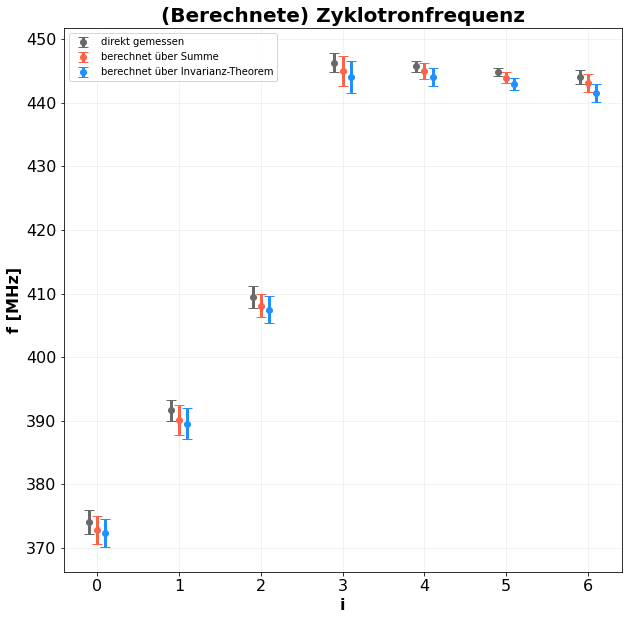

In [31]:
f_c, f_c_err = np.array(complete['$f_{c}$ [MHz]']), np.array(complete['$\sigma_{f_c}$ [MHz]'])
f_s, f_s_err = np.array(complete['$f_{s}$ [MHz]']), np.array(complete['$\sigma_{f_{s}}$ [MHz]'])
f_i, f_i_err = np.array(complete['$f_{i}$ [MHz]']), np.array(complete['$\sigma_{f_{i}}$ [MHz]'])
i = np.arange(0,len(f_c))

plt.figure(figsize=(10,10))
plt.title('(Berechnete) Zyklotronfrequenz')
plt.xlabel('i')
plt.ylabel('f [MHz]')
plt.errorbar(x=i-0.1, y=f_c, yerr=f_c_err, label='direkt gemessen',      fmt='o', capsize=5, color='dimgray')
plt.errorbar(x=i, y=f_s, yerr=f_s_err, label='berechnet über Summe', fmt='o', capsize=5, color='tomato')
plt.errorbar(x=i+0.1, y=f_i, yerr=f_i_err, label='berechnet über Invarianz-Theorem', fmt='o', capsize=5, c='dodgerblue')
#plt.ylim(440,448)
plt.legend()
plt.grid(alpha=0.2)

Die Werte Summen-Werte stimmen im $1\sigma$-Bereich mit den direkt gemessenen Werten über ein. Die Invarianz-Werte weichen deutlicher ab, insgesamt zeigen alle berechneten Werte eine systematische Abweichung nach unten.

### 11. Axiale und Zyklotronfrequenzen

Wir analysieren 2 Abhängigkeiten:
- $f_{z}(V_0)$
- $f_{c}(I_{coil})$

#### 11.1 $f_{z}(V_0)$
Es wird ein Wurzel-Zusammenhang erwartet:
$$f_z = \frac{1}{2\pi}\sqrt{2V_0C_2\frac{q}{m}} = c\cdot \sqrt{V_0}$$


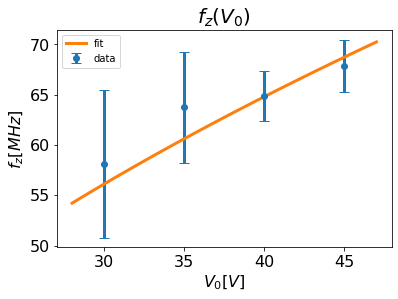

In [32]:
f_z_data = pd.DataFrame(AXIAL[2:6])
f_z, f_z_err, V_0 = np.array(f_z_data['f']), np.array(f_z_data['sigma']), np.array(f_z_data['U'])

def mysqrt(x, c):
    return c*np.sqrt(x)

plt.title('$f_z (V_0)$')
plt.errorbar(x=V_0, y=f_z, yerr=f_z_err, fmt='o', capsize=5, label='data')
plt.xlabel('$V_0 [V]$')
plt.ylabel('$f_z [MHz]$')

popt, pcov = curve_fit(mysqrt, V_0, f_z, sigma=f_z_err)
c, c_err = popt[0], pcov[0][0]**0.5

V_line = np.linspace(28,47,100)
plt.plot(V_line, mysqrt(V_line, c), label='fit')
plt.legend()
plt.show()

Wir haben nur 4 Werte und die Fehler sind sehr groß, es ist also schwer eine vernünftige Aussage zu machen.

#### 11.2 $f_{c}(I_{coil})$
Es wird ein linearer Zusammenhang erwartet:
$$f_c = \frac{q}{m} \cdot B = \frac{q}{m} \frac{\mu N I}{L} = a \cdot I$$

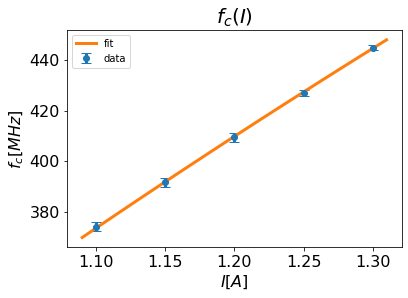

In [33]:
f_c_data = pd.DataFrame(ZYKLOTRON[-5:])
f_c, f_c_err, I = np.array(f_c_data['f']), np.array(f_c_data['sigma']), np.array(f_c_data['I'])
def line(x, a, b):
    return a*np.sqrt(x) + b

plt.title('$f_c (I)$')
plt.errorbar(x=I, y=f_c, yerr=f_c_err, fmt='o', capsize=5, label='data')
plt.xlabel('$I [A]$')
plt.ylabel('$f_c [MHz]$')

popt, pcov = curve_fit(line, I, f_c, sigma=f_c_err)
a, a_err = popt[0], pcov[0][0]**0.5

I_line = np.linspace(1.09,1.31,100)
plt.plot(I_line, line(I_line, *popt), label='fit')
plt.legend()
plt.show()

Die Erwartung des linearen Zusammenhangs bestätigt sich.

### 12. Bestimmung der magnetischen Flussdichte $B$ und des $C_2$-Koeffizienten 

#### 12.1 $C_2$-Koeffizient
In Abschnitt 11 wurde eine Wurzel-Funktion gefittet mit dem Parameter:
$$c = \frac{\sqrt{2C_2\frac{q}{m}}}{2\pi} =  \sqrt{\frac{C_2q}{2m\pi^2}}$$
Womit folgt: 
$$C_2 = \frac{2\pi^2 m}{q} \cdot c^2$$ 
mit 
$$\sigma_{C_2} = \frac{2\pi^2 m}{q} \cdot c \cdot \sigma_c$$

In [34]:
c_ =c*1e6
c_err_ =c_err*1e6
C_2 = 2*np.pi**2*m_e*c_**2/e
C_2_err = 2*np.pi**2*m_e*c_*c_err_/e

print(f'C_2 = ({np.round(C_2,-1)} +- {np.round(C_2_err,-1)}) m^(-2)')

C_2 = (11780.0 +- 120.0) m^(-2)


In Abschnitt 6 haben wir $C_2 = 1.17\cdot10^4m^{-2}$ abgeschätzt. Die Werte stimmen also sehr gut überein.

#### 12.2 Flusdichte $B$

Zum Vergleich mit Abschnitt 6 berechnen wir den das B-Feld für $I=1.3 A$ und nehmen den Mittelwert der gemessenen Zyklotronfrequenzen für variable Spannung/Leistung. Dann folgt
$$ B= \omega_c \cdot \frac{q}{m} = (15.90 \pm 0.03) mT$$
mit $ \Delta B = \Delta f_c \cdot 2\pi \cdot \frac{m_e}{e}$. Der Wert liegt in guter Übereinstimmung mit dem Schätzwert aus Abschnitt 6 ($B=0.016 T$) und dem berechneten Wert aus Abschnitt 13.

In [35]:
f_c_data_coilconst = pd.DataFrame(ZYKLOTRON[0:6])
f_c_coilconst, f_c_coilconst_err = np.array(f_c_data_coilconst['f']), np.array(f_c_data_coilconst['sigma'])
f_c_mean=np.mean(f_c_coilconst)
f_c_mean_err = np.std(f_c_coilconst, ddof=1)
print(f'f_c = ({np.round(f_c_mean,1)} +- {np.round(f_c_mean_err,1)}) MHz')
B = f_c_mean*1e6*2*np.pi*m_e/e
B_err = f_c_mean_err*1e6*2*np.pi*m_e/e
print(f'B = ({np.round(B,5)} +- {np.round(B_err,5)} T)')

f_c = (445.1 +- 0.8) MHz
B = (0.0159 +- 3e-05 T)


### 13. Ladung-Masse-Verhältnis und Masse des Elektrons

Unter der Annahme, das die Angaben der Spule $N = (2400 \pm 30)$ und $L = (246.0\pm0.5)mm$ korrekt sind kann die B-Feldstärke berechnet werden:
$$B = \mu_0 \cdot \frac{N}{L} \cdot I = (0.0159\pm0.0012)T$$
wobei der Wert $I = (1.3 \pm 0.1) A$ verwendet wurde. Der Fehler wird über den rel. Fehler $\frac{\Delta B}{B} = \sqrt{\left(\frac{\Delta N}{N}\right)^2 + \left(\frac{\Delta I}{I}\right)^2 + \left(\frac{\Delta L}{L}\right)^2}$  
Unter Verwendung der Zyklotron-Frequenz aus Abschnitt 12.2 berechnen wir jetzt das Masse/Ladungs-Verhältnis des Elektrons: $$ \frac{m_e}{e} = \frac{B}{\omega_c}= \qquad mit\qquad \Delta \frac{m_e}{e} = \frac{m_e}{e} \cdot \sqrt{\left( \frac{\Delta B}{B}\right)^2 + \left( \frac{\Delta \omega_c}{\omega_c}\right)^2} $$
Mit dem Wert die Elementarladung (Scipy constants und CODATA stimmen überein, die Elementarladung ist eine definierte Größe und hat keinen Fehler) ergibt sich für die Elektronenmasse:
$$ m_e = (9.1 \pm 0.7) \cdot 10^{-31} kg \qquad mit \quad \Delta m_e = \Delta (\frac{m_e}{e}) \cdot e_{exakt} $$
Der Wert ist in gute Übereinstimmung mit dem Literaturwert $m_e = 9.10938...\cdot 10^{-31}kg$, hat allerdings noch einen relativen Fehler von $\approx 7\%$. Der relative Fehler des B-Felds ist weit größer als der Fehler von $f_c$, daher müsste in erster Linie das B-Feld genauer bestimmt werden.

In [36]:
ratio = B/(f_c_mean*1e6*2*np.pi)
ratio_err = ratio*np.sqrt((0.0012/B)**2+(f_c_mean_err/f_c_mean)**2)
print(f'm/e = ({np.round(ratio,14)} +- {np.round(ratio_err,14)}) kg/C')
e_mass = ratio*e
e_mass_err = ratio_err*e
print(f'm_e = ({np.round(e_mass,32)} +- {np.round(e_mass_err,32)}) kg')

m/e = (5.69e-12 +- 4.3e-13) kg/C
m_e = (9.100000000000002e-31 +- 7.000000000000001e-32) kg
